In [2]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [7]:
df = pd.read_csv('cisplatin_GDSC1.csv')
df

,Unnamed: 0,drug,cell_line,name,tissue,histology,log10_dose,viability
0,1,CISPLATIN,924238,K5,thyroid,carcinoma,-1.408240,0.931629
1,2,CISPLATIN,924238,K5,thyroid,carcinoma,-1.107210,0.772518
2,3,CISPLATIN,924238,K5,thyroid,carcinoma,-0.806180,0.747044
3,4,CISPLATIN,924238,K5,thyroid,carcinoma,-0.505150,0.856572
4,5,CISPLATIN,924238,K5,thyroid,carcinoma,-0.204120,0.878915
...,...,...,...,...,...,...,...,...
8590,8591,CISPLATIN,688026,NCI-H64,lung,carcinoma,-0.425969,0.980248
8591,8592,CISPLATIN,688026,NCI-H64,lung,carcinoma,-0.124939,0.958733
8592,8593,CISPLATIN,688026,NCI-H64,lung,carcinoma,0.176091,0.905251
8593,8594,CISPLATIN,688026,NCI-H64,lung,carcinoma,0.477121,0.921236


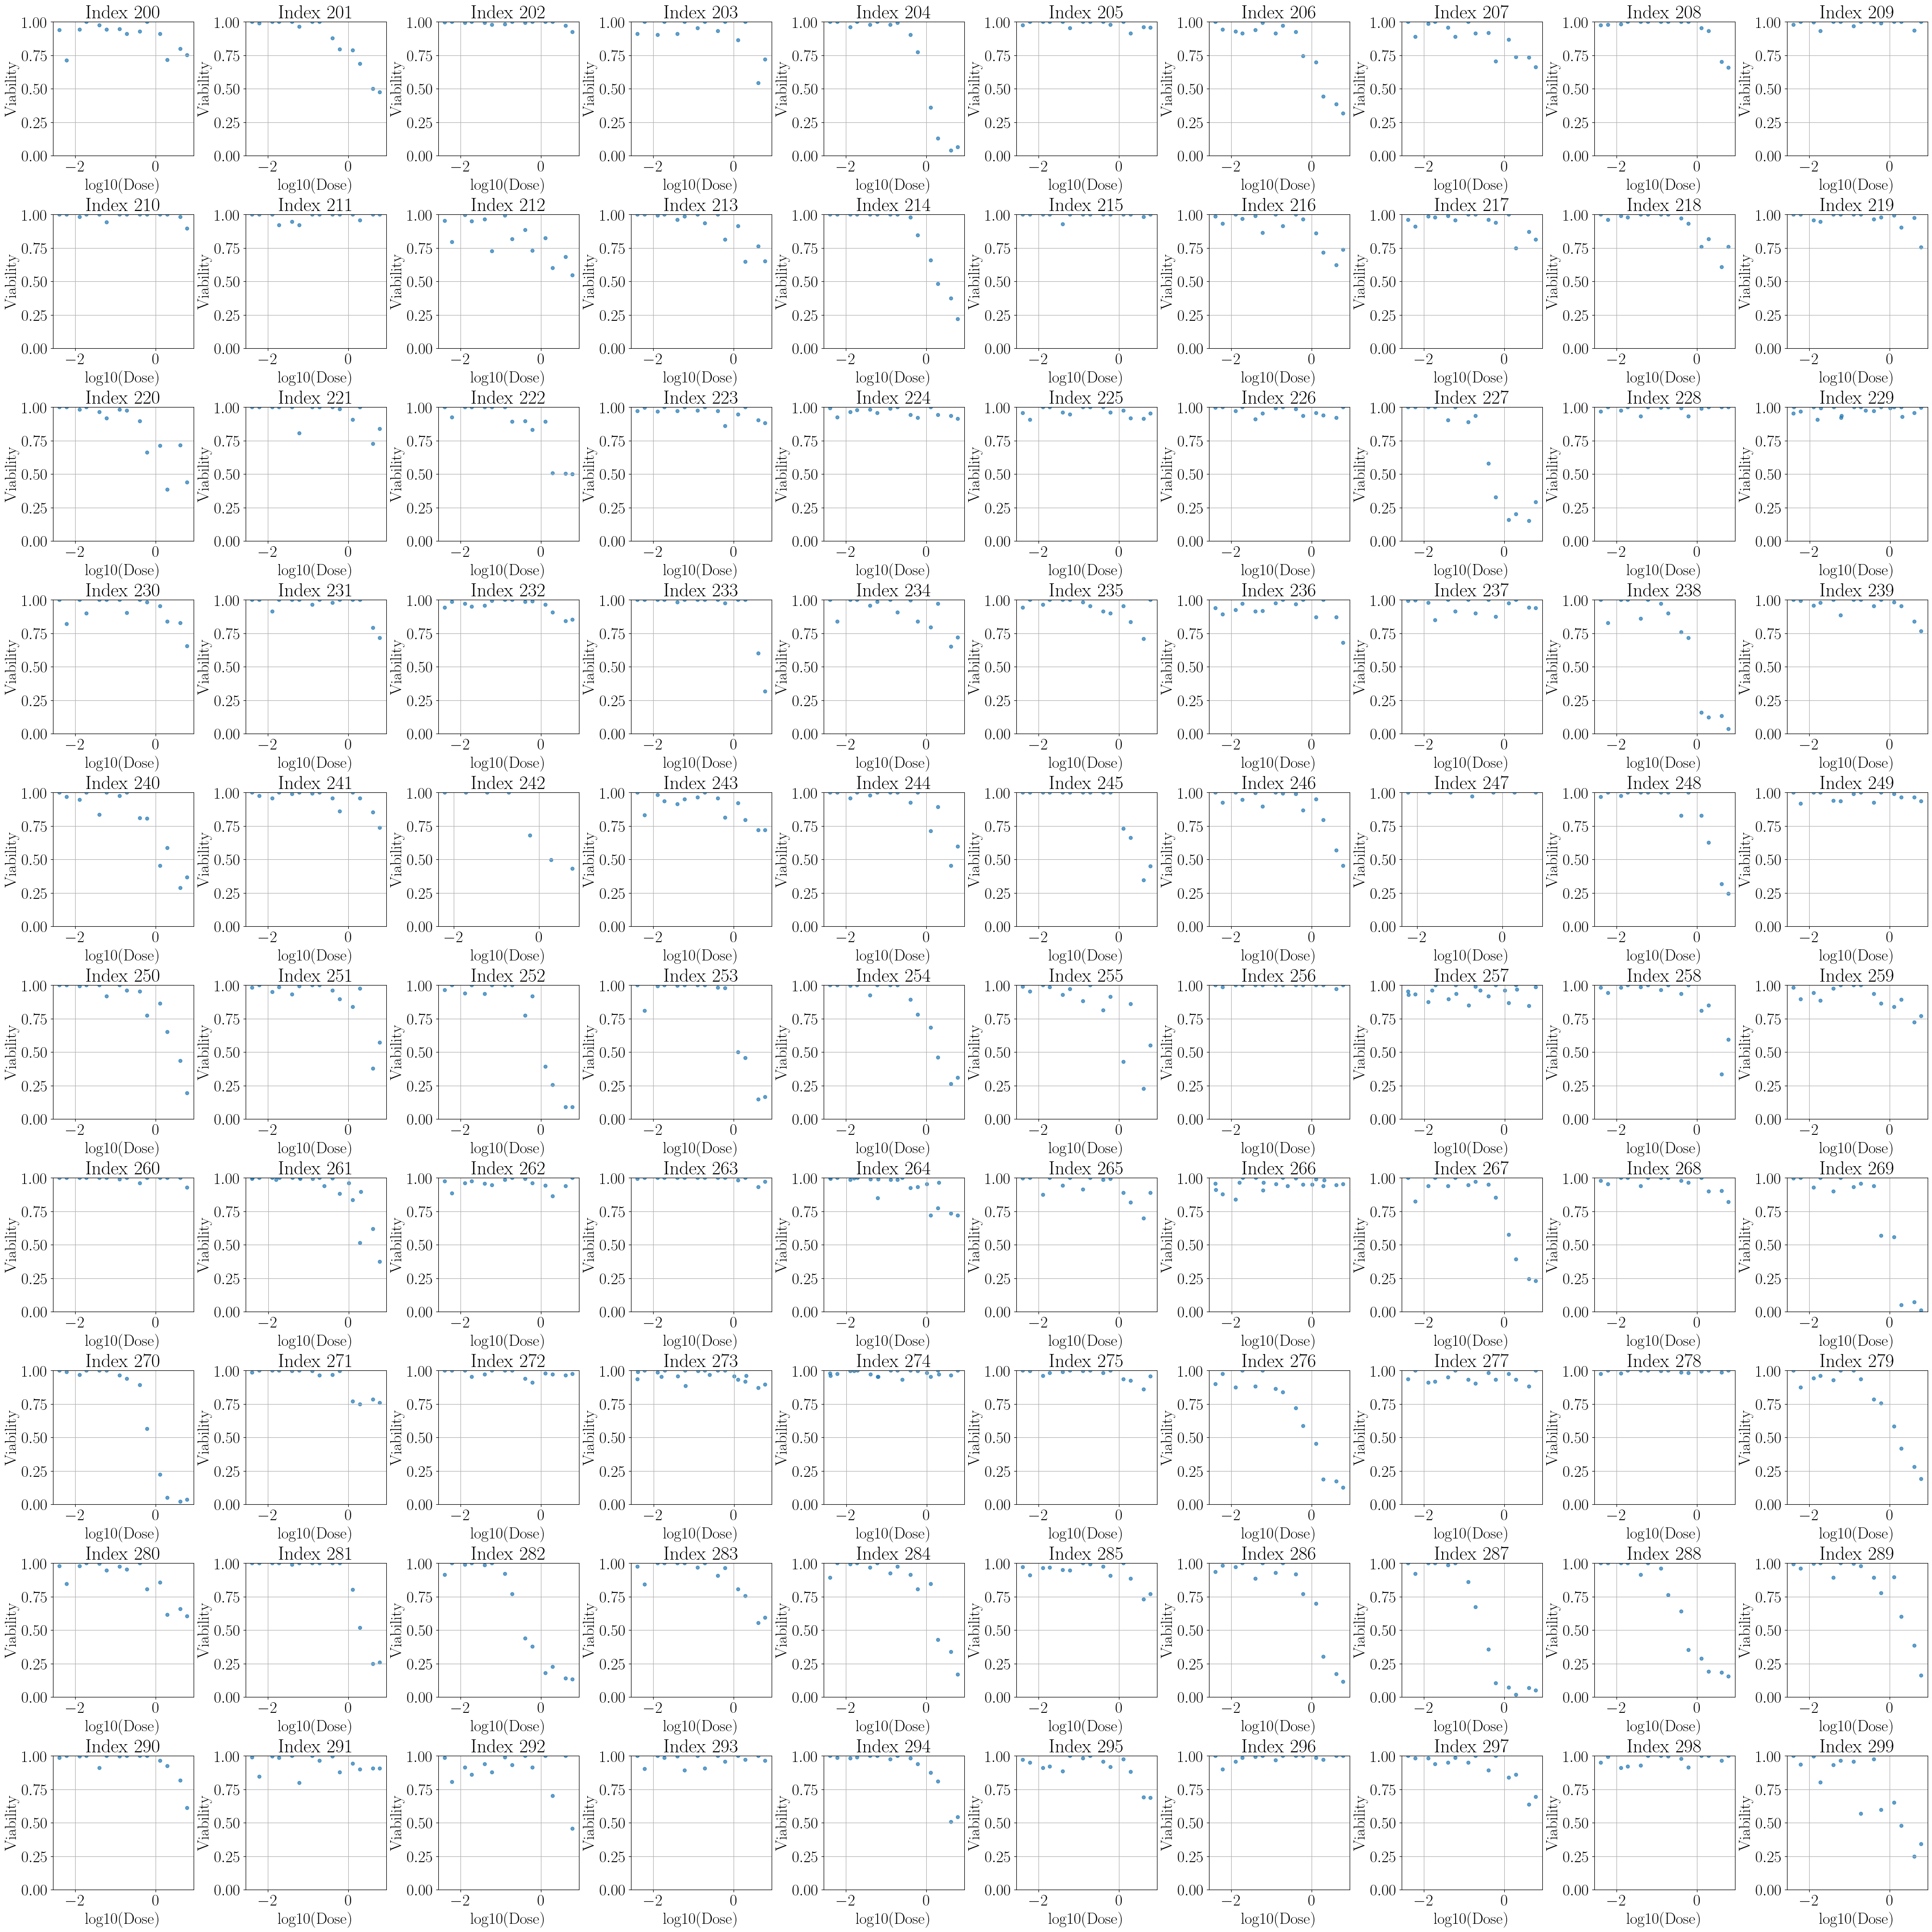

In [6]:
def visual_examples(df, k, begin_idx):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[begin_idx + i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Index {begin_idx + i}')
                    #  , \n Name: {df_n["name"].iloc[0]}, \n Tissue: {df_n["tissue"].iloc[0]}', fontsize=16)
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(0, 1)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 100, 200)

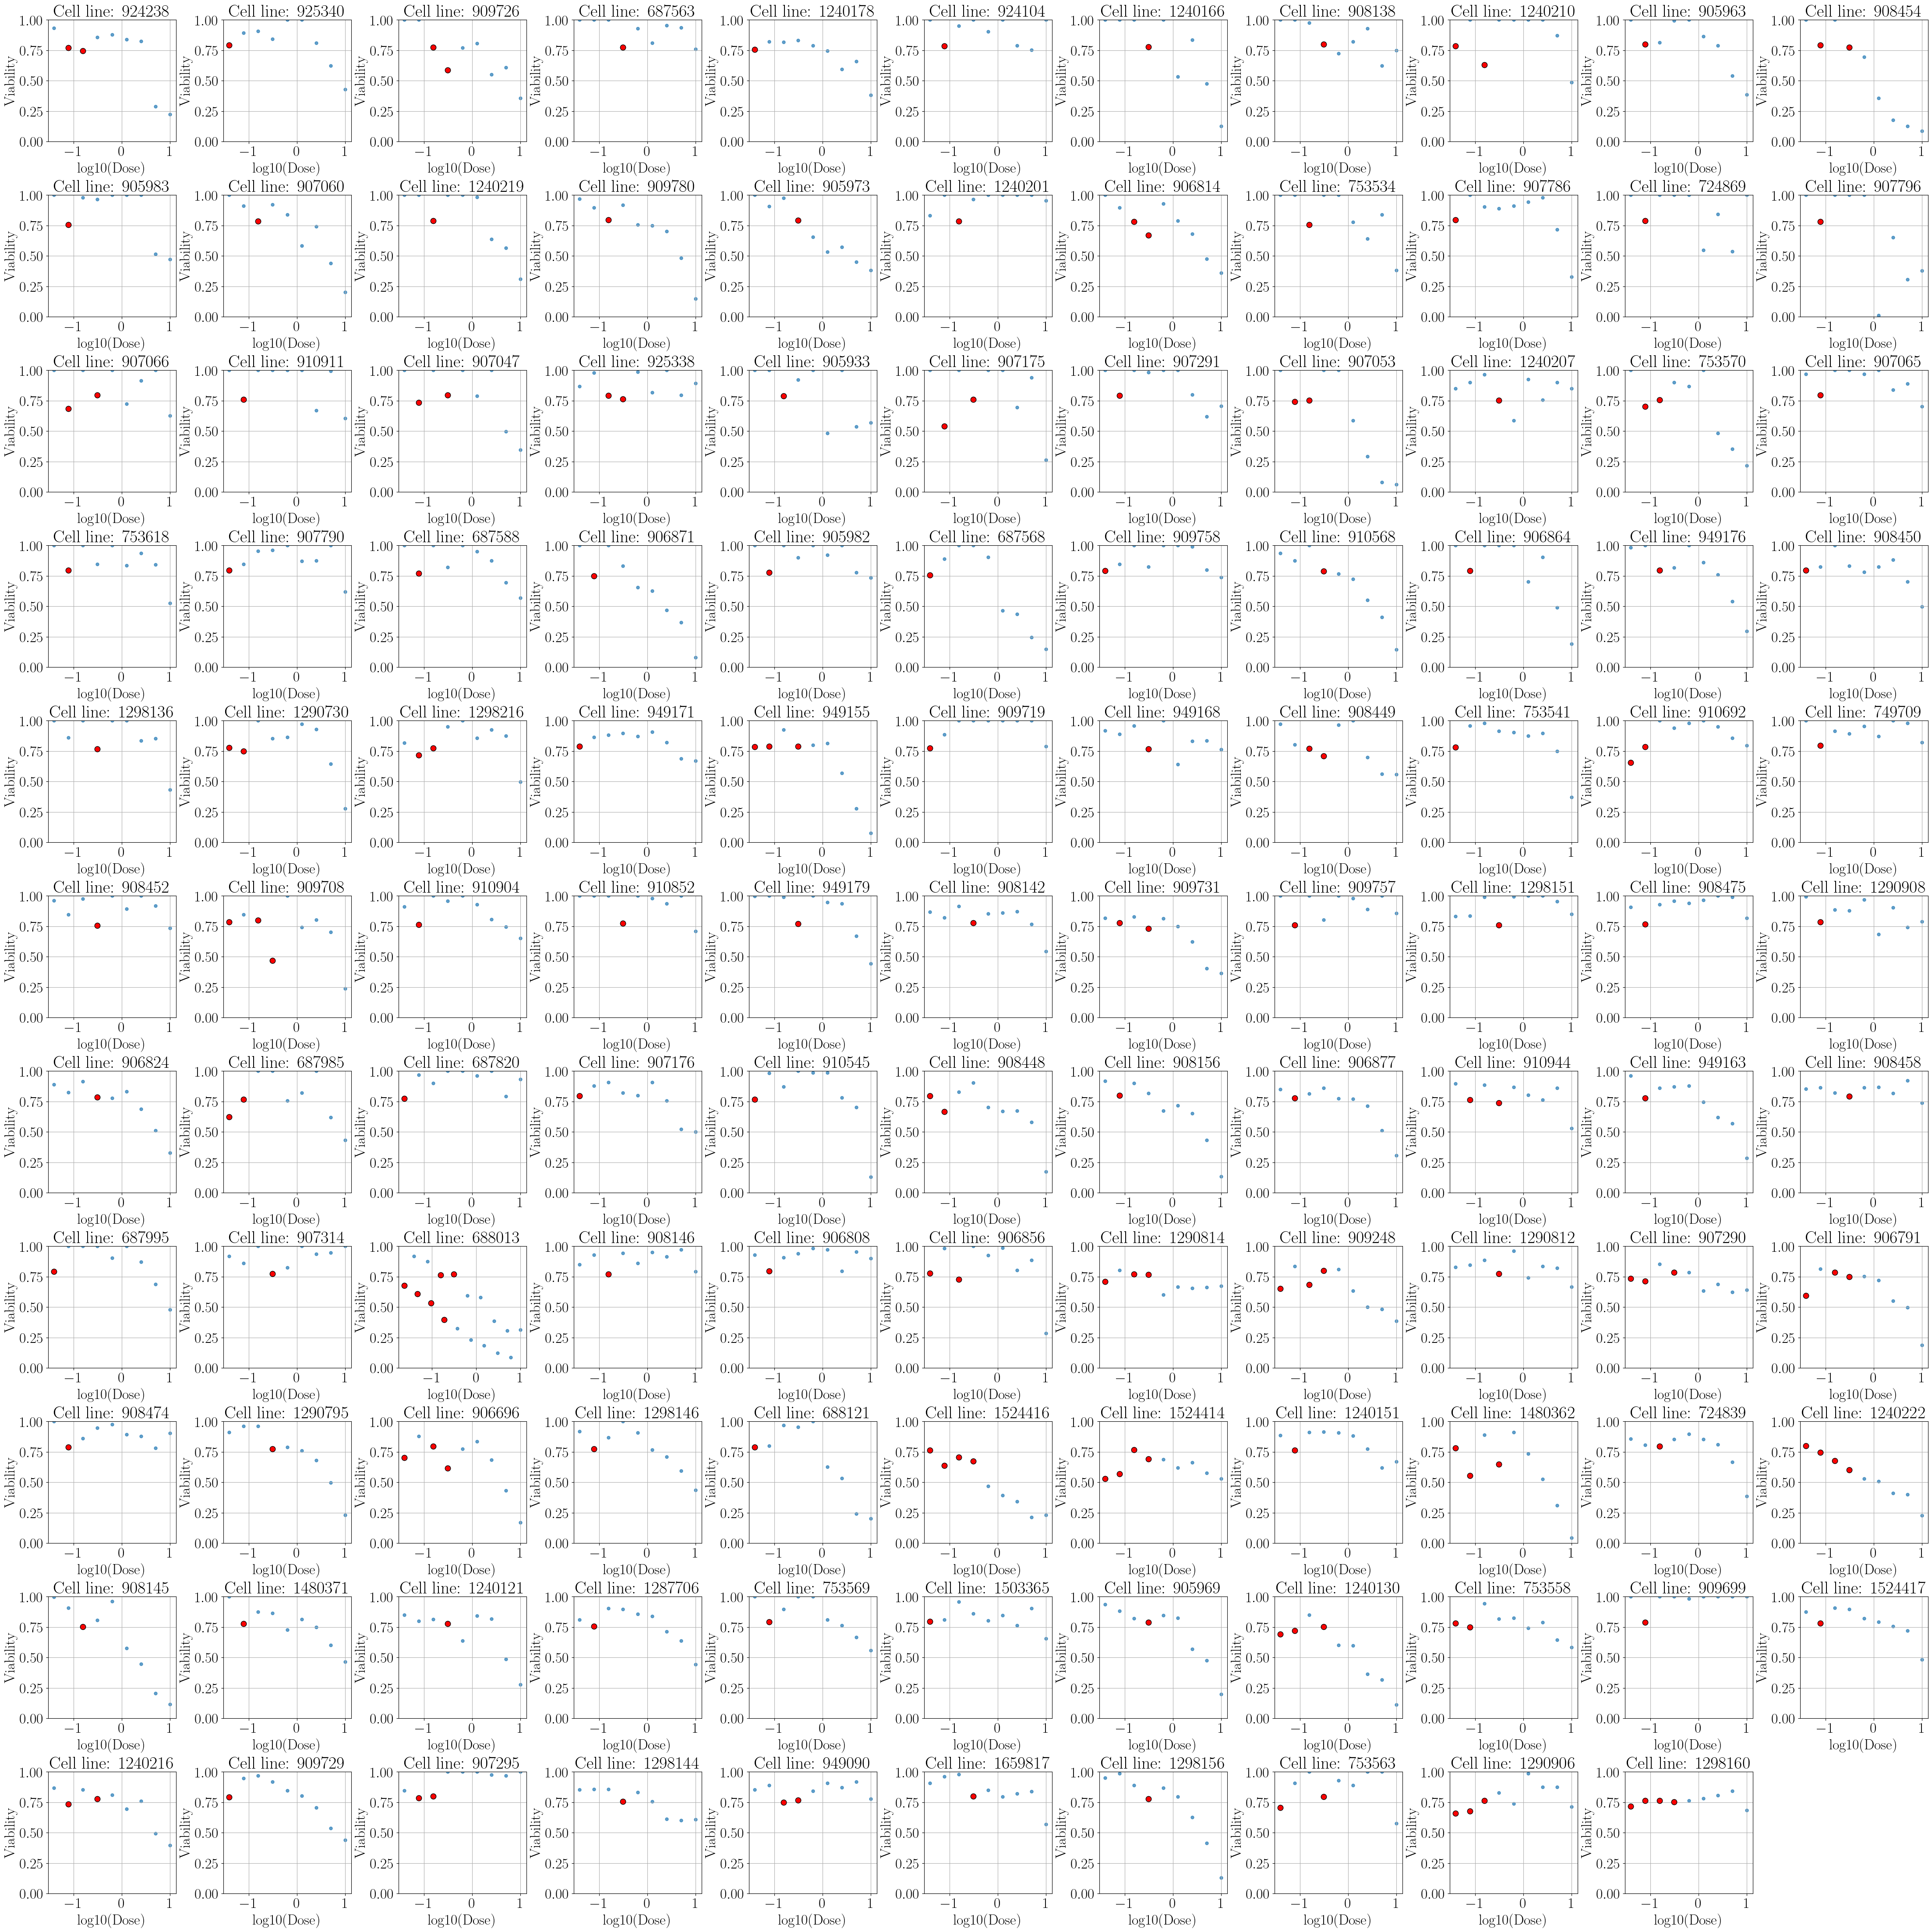

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def plot_outlier_examples(df, q, p, max_plots=20):
    """
    Plots scatterplots of cell lines that contain at least one point
    with log10_dose < -1 and viability < p.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['cell_line', 'log10_dose', 'viability'].
    p : float
        Threshold for viability.
    max_plots : int, optional
        Maximum number of cell lines to plot (default=20).
    """
    
    # Condition for outliers
    condition = (df['log10_dose'] < -0.5) & (df['viability'] < p) & (df['viability'] > q)

    # Get unique cell lines with at least one outlier
    outlier_lines = df.loc[condition, 'cell_line'].unique()

    if len(outlier_lines) == 0:
        print("No cell lines found with outliers matching the condition.")
        return

    # Limit number of plots if necessary
    k = min(len(outlier_lines), max_plots)

    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)
    axes = axes.flatten()

    for i, cell_line in enumerate(outlier_lines[:k]):
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)

        # Highlight the outlier points
        outliers = df_n[(df_n['log10_dose'] < -0.5) & (df_n['viability'] < p)]
        ax.scatter(outliers['log10_dose'], outliers['viability'], 
                   color='red', edgecolor='black', s=80, zorder=3)

        # Find the first index in the original dataset where this cell line appears
        first_cellline_idx = df[df['cell_line'] == cell_line].index[0]

        # Title with index info
        ax.set_title(f"Cell line: {cell_line}")
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)
        ax.set_ylim(0, 1)

    # Hide unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()


plot_outlier_examples(df, 0.75, 0.8, max_plots=1000)

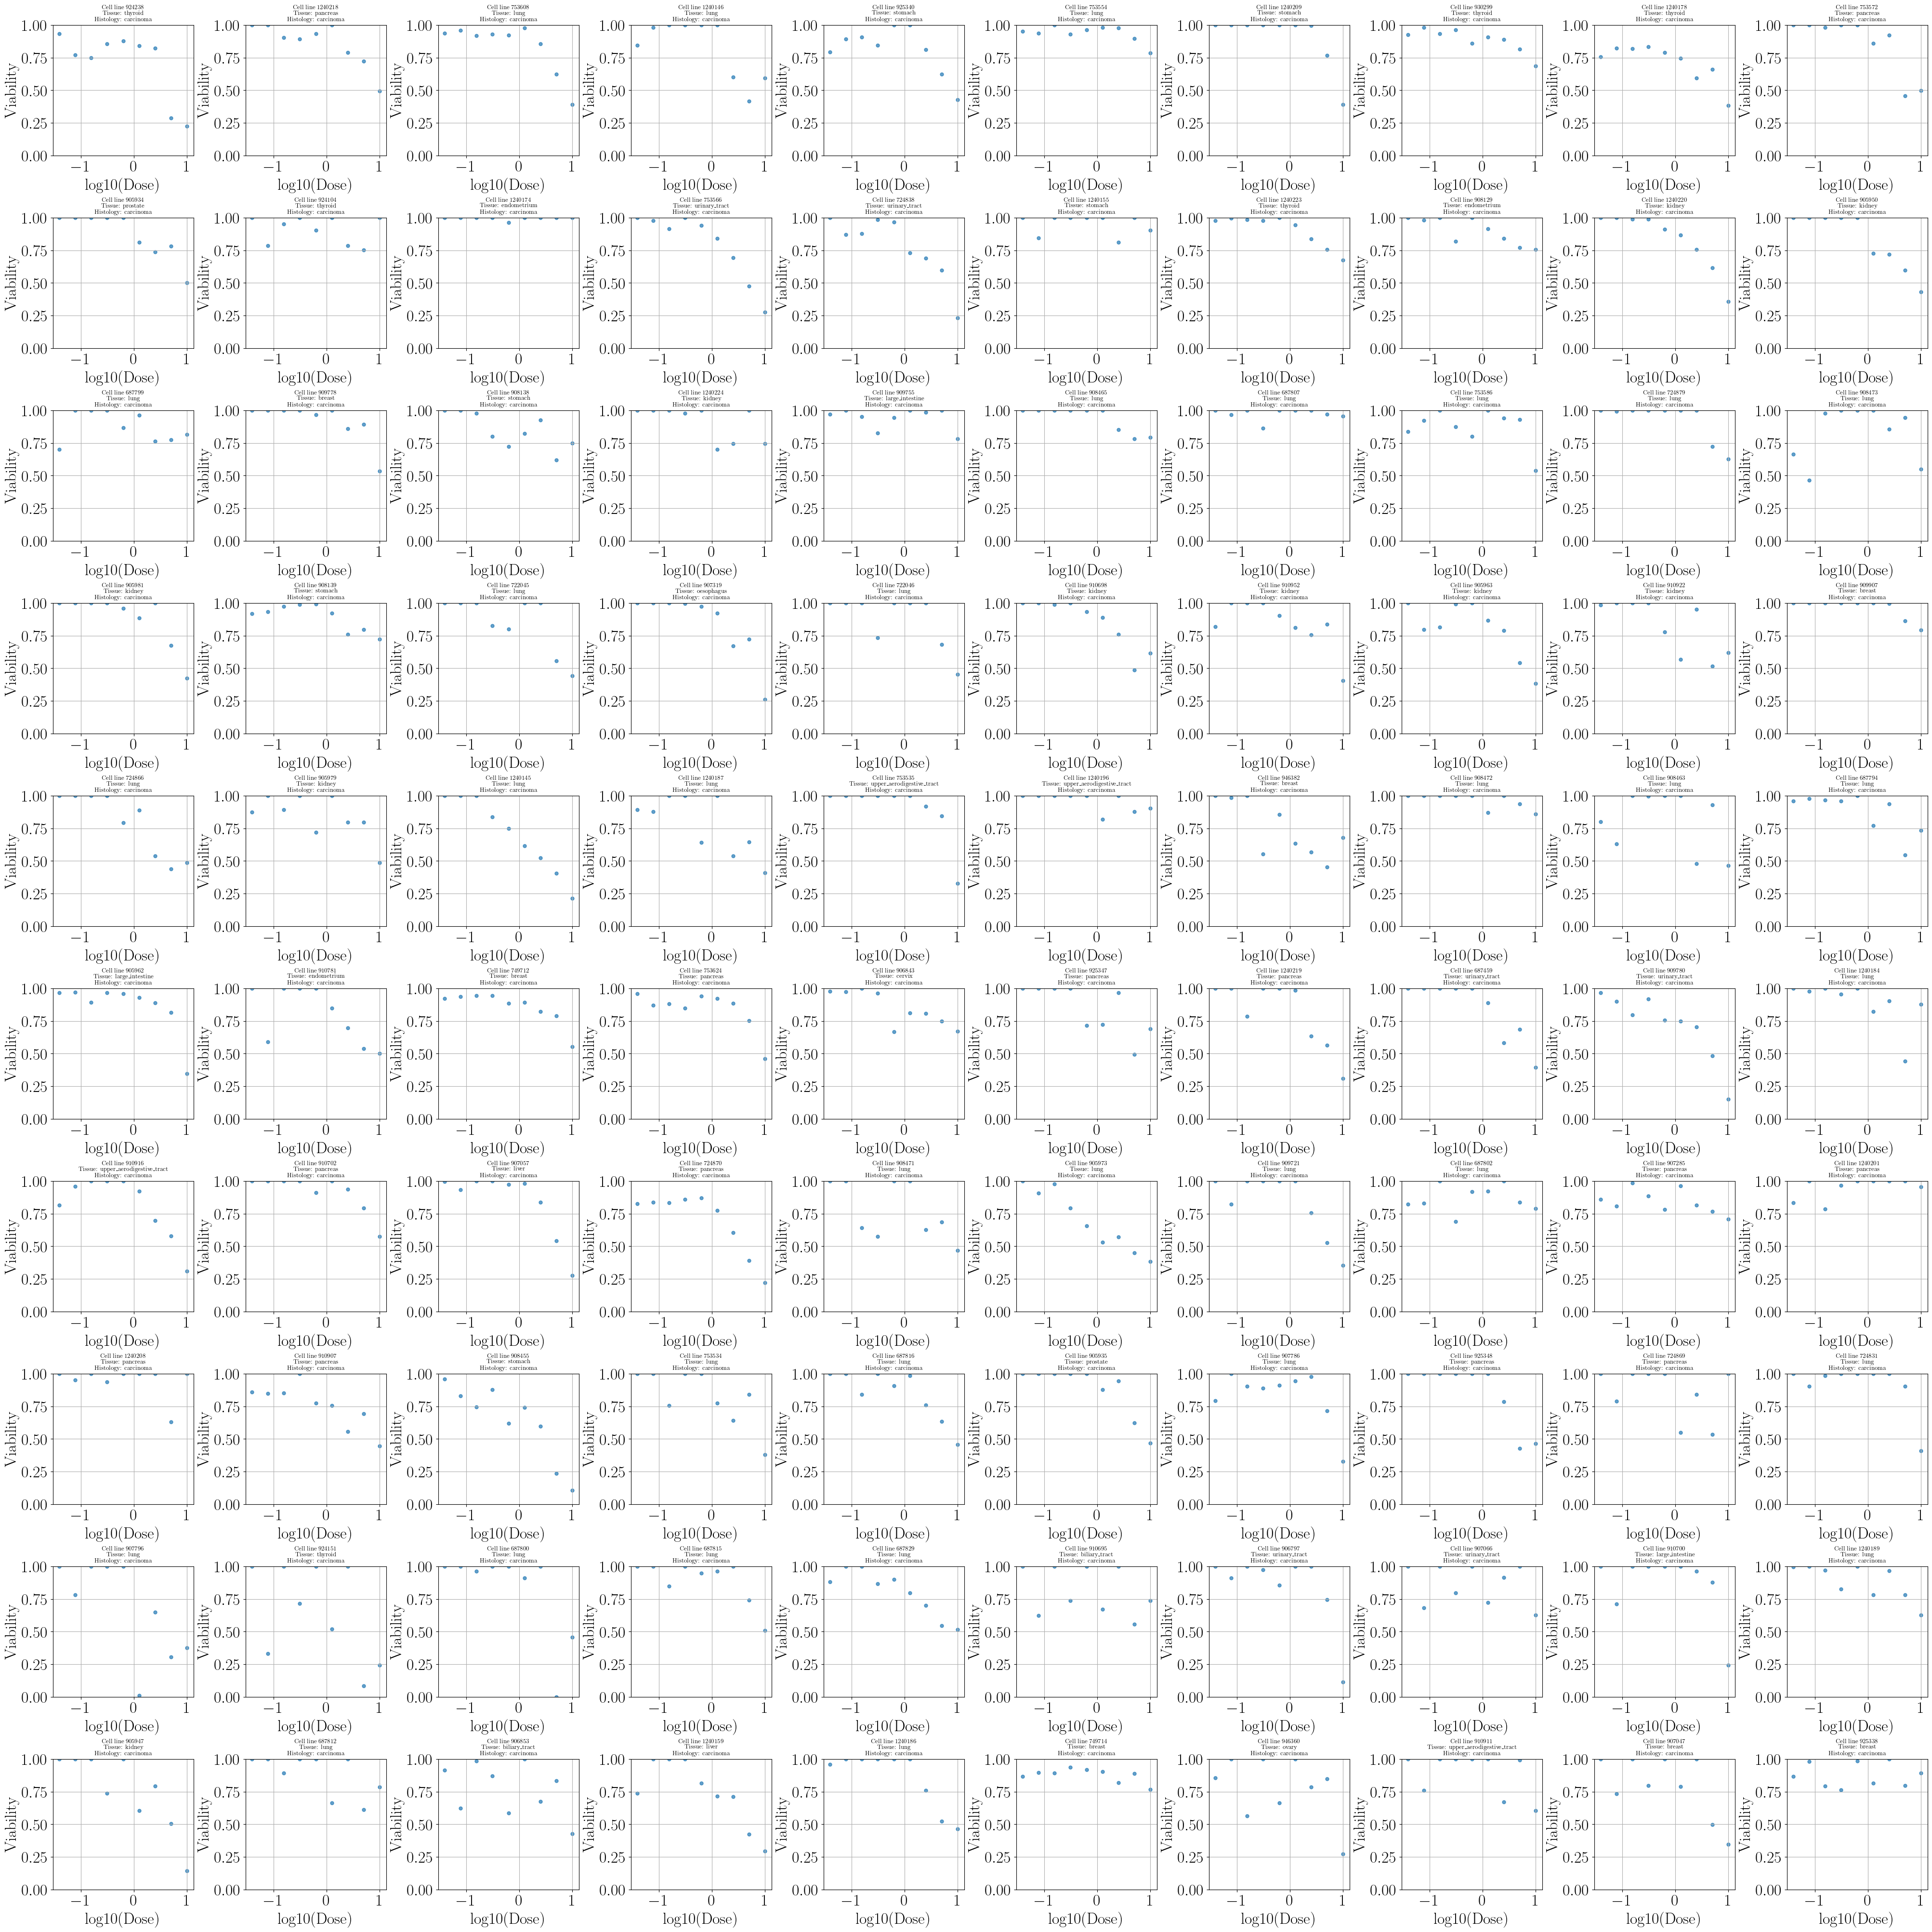

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def visual_examples_histology(df, histologies, max_plots=16, begin_idx=0):
    """
    Visualize cell line dose-response data filtered by histologies, showing cell line number instead of name.

    Parameters:
    - df: DataFrame containing columns 'cell_line', 'log10_dose', 'viability', 'tissue', 'histology'
    - histologies: list of histology strings to filter by
    - max_plots: maximum number of cell lines to visualize
    - begin_idx: index in the filtered cell line list to start plotting from
    """
    # Filter based on histologies
    df_filtered = df[df['histology'].isin(histologies)]
    unique_cell_lines = df_filtered['cell_line'].unique()
    
    if begin_idx >= len(unique_cell_lines):
        print("begin_idx is larger than the number of filtered cell lines.")
        return
    
    k = min(max_plots, len(unique_cell_lines) - begin_idx)
    if k == 0:
        print("No cell lines to plot from the given begin_idx.")
        return

    # Determine grid layout
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[begin_idx + i]
        df_n = df_filtered[df_filtered['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)

        # Title with cell line number, tissue, histology
        tissue = df_n['tissue'].iloc[0]
        histology = df_n['histology'].iloc[0]
        title_text = f"Cell line {cell_line}\nTissue: {tissue}\nHistology: {histology}"
        ax.set_title(title_text, fontsize=9, loc='center')

        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.set_ylim(0, 1)
        ax.grid(True)

    # Hide unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

# histologies_of_interest = ['carcinoma', 'adrenal_cortical_carcinoma', 'choriocarcinoma']
histologies_of_interest = ['carcinoma']

visual_examples_histology(df, histologies_of_interest, max_plots=100, begin_idx=0)

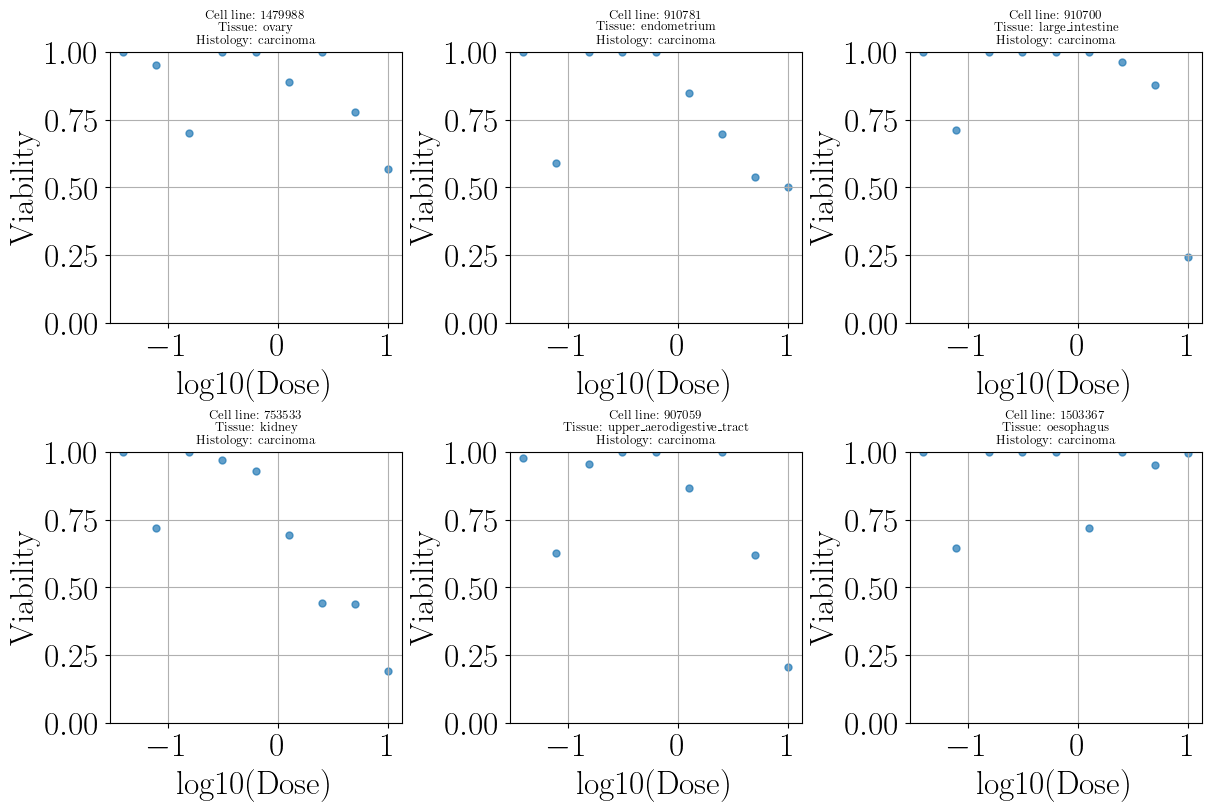

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_selected_cell_lines(df, cell_lines, max_plots=20):
    """
    Plots scatterplots for given cell lines, showing their name, tissue, and histology.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['cell_line', 'log10_dose', 'viability', 'tissue', 'histology'].
    cell_lines : list
        List of cell line identifiers (values from 'cell_line' column).
    max_plots : int, optional
        Maximum number of cell lines to plot (default=20).
    """
    # Filter the cell lines to those in the dataframe
    selected_lines = [cl for cl in cell_lines if cl in df['cell_line'].unique()]
    if not selected_lines:
        print("No matching cell lines found in dataframe.")
        return

    # Limit number of plots
    k = min(len(selected_lines), max_plots)

    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)
    axes = axes.flatten()

    for i, cell_line in enumerate(selected_lines[:k]):
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)

        # Extract metadata: take the first row for tissue/histology
        row_info = df_n.iloc[0]
        name = row_info['cell_line']
        tissue = row_info['tissue']
        histology = row_info['histology']

        # Multi-line title with smaller font
        title_text = f"Cell line: {name}\nTissue: {tissue}\nHistology: {histology}"
        ax.set_title(title_text, fontsize=9, loc='center')

        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)
        ax.set_ylim(0, 1)

    # Hide unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

# chosen_cell_lines = [907058, 906999, 910781, 909745, 910700, 753533, 907059, 908470, 1503367, 987586, 1479988, 910780, 687586, 724825]
chosen_cell_lines = [1479988, 910781, 910700, 753533, 907059, 1503367]
# chosen_cell_lines = [1479988, 910700, 1240223, 909778, 1240220, 905981, 907319, 905935]

plot_selected_cell_lines(df, chosen_cell_lines)